In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import gymnax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
import time

import sys
sys.path.insert(0, '..')  # adds the root directory to the path

from policy_distillation.behaviour_clone import BCAgent, Transition, make_train
import matplotlib.pyplot as plt

# Meta-learning the Dataset

## Setup

In [2]:
from evosax import OpenES, ParameterReshaper

env_name = "CartPole-v1"
env, env_params = gymnax.make(env_name)
env = FlattenObservationWrapper(env)
env = LogWrapper(env)

n_actions = env.action_space(env_params).n

config = {
    "LR": 5e-2,  # 5e-3      # 2.5e-2 to 5e-2 brings BC loss to ~0 for UPDATE_EPOCHS=10 and up to 100 states/action
    "NUM_ENVS": 16,   #8 # Num eval envs
    "NUM_STEPS": 512,   #128 # Max num eval steps per env
    "UPDATE_EPOCHS": 10,  # Num BC gradient steps
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "WIDTH" : 64,
    "ENV_NAME": env_name,
    "ANNEAL_LR": True,
    "GREEDY_ACT": True,  # Whether to use greedy act in env or sample
    "ENV_PARAMS" : {}
}

es_config = {
    "popsize": 500,  # Num of candidates
    "dataset_size": n_actions * 1, #10 #20000,  # Num of (s,a) pairs (split evenly across actions)
    "rollouts_per_candidate": 16,  #32 Num of BC policies trained per candidate
    "n_generations": 10,
    "log_interval": 1,
}

params = jnp.zeros(
    (es_config["dataset_size"], *env.observation_space(env_params).shape)
)
param_reshaper = ParameterReshaper(params)

rng = jax.random.PRNGKey(0)

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 8 parameters detected for optimization.


## Sampling real data

In [3]:
from tqdm import tqdm
# rng, reset_rng = jax.random.split(rng)
# obs, env_state = env.reset(reset_rng, env_params)

# obs_list = []
# action_list = []
# dones_list = []

# # Small chance of not gathering enough data, but it doesn't matter in practice
# for t in tqdm(range(es_config["dataset_size"] * 10)):
#     rng, rng_act, rng_step = jax.random.split(rng, 3)
#     action = jax.random.choice(rng_act, a=jnp.arange(n_actions))
#     action_list.append(action.item())
    
#     obs, env_state, reward, done, info = env.step(rng_step, env_state, action, env_params)
#     obs_list.append(obs)    
    
# action_list = jnp.array(action_list)
# obs_list = jnp.array(obs_list)

# dataset = []
# for a in range(n_actions):
#     obs_for_action = obs_list[action_list == a]
#     rng, rng_shuffle = jax.random.split(rng)
#     dataset.append(jax.random.shuffle(rng_shuffle, obs_for_action, axis=0)[0:es_config["dataset_size"]//n_actions])
    
# sampled_data = jnp.array(dataset).flatten()
# print(sampled_data.shape)

# print(sampled_data.reshape(2,4))

## Initialize Strategy

In [4]:
# Initialize OpenES Strategy
# rng = jax.random.PRNGKey(0)
rng, rng_init = jax.random.split(rng)

strategy = OpenES(
    popsize=es_config["popsize"],
    num_dims=param_reshaper.total_params,
    opt_name="adam",
    maximize=True,
)

# Replace state mean with real observations
# state = state.replace(mean = sampled_data)

es_params = strategy.default_params
# es_params = es_params.replace(init_max=1.0)
state = strategy.initialize(rng_init, es_params)


def get_action_labels(d_size, n_actions):
    action_labels = jnp.array([i % n_actions for i in range(d_size)])
    action_labels = action_labels.sort()
    return action_labels


# Set up vectorized fitness function
train_fn = make_train(config)
action_labels = get_action_labels(es_config["dataset_size"], n_actions)


def single_seed_BC(rng_input, dataset):
    out = train_fn(dataset, action_labels, rng_input)
    return out  # ["metrics"]['returned_episode_returns'].mean()


multi_seed_BC = jax.vmap(single_seed_BC, in_axes=(0, None))  # Vectorize over seeds
train_and_eval = jax.jit(jax.vmap(multi_seed_BC, in_axes=(None, 0)))  # Vectorize over datasets

if len(jax.devices()) > 1:
    train_and_eval = jax.pmap(train_and_eval, in_axes=(None, 0))

## Run OpenES loop

In [5]:
start = time.time()
lap_start = start
fitness_over_gen = []
max_fitness_over_gen = []
for gen in range(es_config["n_generations"]):
    # Gen new dataset
    rng, rng_ask, rng_inner = jax.random.split(rng, 3)
    datasets, state = jax.jit(strategy.ask)(rng_ask, state, es_params)
    # Eval fitness
    batch_rng = jax.random.split(rng_inner, es_config["rollouts_per_candidate"])
    # Preemptively overwrite to reduce memory load
    out = None
    returns = None
    dones = None
    fitness = None
    shaped_datasets = None

    with jax.disable_jit(False):
        shaped_datasets = param_reshaper.reshape(datasets)
        out = train_and_eval(batch_rng, shaped_datasets)

        returns = out["metrics"]["returned_episode_returns"]  # dim=(popsize, rollouts, num_steps, num_envs)
        dones = out["metrics"]["returned_episode"]  # same dim, True for last steps, False otherwise
        
        # Division by zero, you idiot
        fitness = (returns * dones).sum(axis=(-1, -2, -3)) / dones.sum(axis=(-1, -2, -3))  # fitness, dim = (popsize)
        fitness = fitness.flatten()    # Necessary if pmap-ing to 2+ devices

    # Update ES strategy with fitness info
    state = jax.jit(strategy.tell)(datasets, fitness, state, es_params)
    fitness_over_gen.append(fitness.mean())
    max_fitness_over_gen.append(fitness.max())

    if gen % es_config["log_interval"] == 0 or gen == 0:
        lap_end = time.time()
        if len(jax.devices()) > 1:
            bc_loss = out["metrics"]["bc_loss"][:,:,:,-1]
            bc_acc = out["metrics"]["bc_accuracy"][:,:,:,-1]
        else:
            bc_loss = out["metrics"]["bc_loss"][:,:,-1]
            bc_acc = out["metrics"]["bc_accuracy"][:,:,-1]
        
        print(
            f"Gen: {gen}, Fitness: {fitness.mean():.2f} +/- {fitness.std():.2f}, "
            + f"Best: {state.best_fitness:.2f}, BC loss: {bc_loss.mean():.2f} +/- {bc_loss.std():.2f}, "
            + f"BC acc: {bc_acc.mean():.2f} +/- {bc_acc.std():.2f}, Lap time: {lap_end-lap_start:.1f}s"
        )
        lap_start = lap_end
print(f"Total time: {(lap_end-start)/60:.1f}min")


Gen: 0, Fitness: 57.36 +/- 86.42, Best: 500.00, BC loss: 0.05 +/- 0.11, BC acc: 0.99 +/- 0.08, Lap time: 6.7s
Gen: 1, Fitness: 207.92 +/- 75.30, Best: 500.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 1.6s
Gen: 2, Fitness: 221.39 +/- 77.66, Best: 500.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 1.1s
Gen: 3, Fitness: 185.43 +/- 108.40, Best: 500.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 1.3s
Gen: 4, Fitness: 155.97 +/- 106.66, Best: 500.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 1.2s
Gen: 5, Fitness: 199.01 +/- 110.14, Best: 500.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 1.2s
Gen: 6, Fitness: 229.52 +/- 99.62, Best: 500.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 1.1s
Gen: 7, Fitness: 257.04 +/- 108.32, Best: 500.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 1.1s
Gen: 8, Fitness: 250.90 +/- 115.50, Best: 500.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 1.

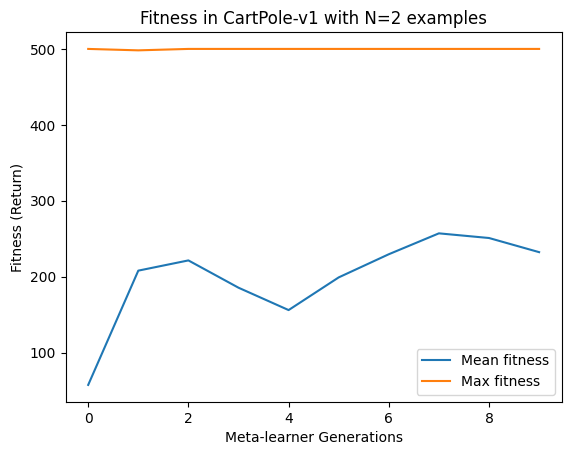

In [6]:
from scipy.signal import savgol_filter
# savgol_filter(y, 20, 3)

y = fitness_over_gen
plt.plot(fitness_over_gen, label="Mean fitness")
y = max_fitness_over_gen
plt.plot(max_fitness_over_gen, label="Max fitness")
plt.title(f"Fitness in CartPole-v1 with N={es_config['dataset_size']} examples")
plt.ylabel("Fitness (Return)")
plt.xlabel("Meta-learner Generations")
plt.legend()
plt.show()

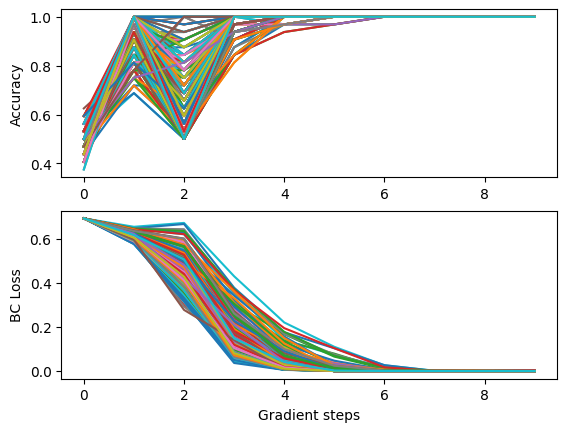

In [7]:
def reshape(arr):
    """Removes extra dim due to pmap"""
    dims = arr.shape
    arr = arr.reshape(-1,dims[-2],dims[-1])
    return arr

fig, ax = plt.subplots(2, 1)
for i in range(es_config["popsize"]):
    acc = reshape(out["metrics"]["bc_accuracy"])[i].mean(axis=0)
    ax[0].plot(acc)
    ax[0].set_ylabel("Accuracy")

    loss = reshape(out["metrics"]["bc_loss"])[i].mean(axis=0)
    ax[1].plot(loss)
    ax[1].set_ylabel("BC Loss")
    ax[1].set_xlabel("Gradient steps")

## Double check policy return

In [8]:
P = es_config["popsize"]
final_datasets_reshaped = param_reshaper.reshape(datasets)

best = fitness.argmax()

if len(jax.devices()) > 1:
    best_idx = (best // (P//2), best % (P//2))
else:
    best_idx = (best % (P//2))

final_dataset = final_datasets_reshaped[best_idx]

train_state = out["runner_state"][0]
# Note: if multiple rollouts / candidate, pick first rollout
if len(jax.devices()) > 1:
    f = lambda x : x[best_idx[0], best_idx[1], 0]
else:
    f = lambda x : x[best_idx, 0]
best_params = jax.tree_util.tree_map(f, train_state.params)

best_ret = returns[best_idx]
best_dones = dones[best_idx]

best_mean_ret  = (best_ret * best_dones).sum(axis=(-1, -2)) /best_dones.sum(axis=(-1, -2))
print("Best mean return per rollout", best_mean_ret)

Best mean return per rollout [500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500.]


In [9]:
## Play policy

# env, env_params = gymnax.make(config["ENV_NAME"])
# env = FlattenObservationWrapper(env)
# env = LogWrapper(env)

# n_actions = env.action_space(env_params).n

# rng = jax.random.PRNGKey(42)
# rng, reset_rng = jax.random.split(rng)
# obs, env_state = env.reset(reset_rng, env_params)

# rewards_per_ep = []

# for t in tqdm(range(512)):
#     rng, rng_act, rng_step = jax.random.split(rng, 3)
    
#     pi = train_state.apply_fn(best_params, obs)
#     action = pi.argmax(axis=-1)
    
#     obs, env_state, reward, done, info = env.step(rng_step, env_state, action, env_params) 
#     rewards_per_ep.append(reward)
#     if done:
#         ep_ret = jnp.array(rewards_per_ep).sum()
#         print("Ep return: ", ep_ret)
#         rewards_per_ep = []


[ 0.05494051 -0.00931629 -0.04791882 -0.15088248]
[0.0624046  0.01932164 0.01562035 0.12035486]


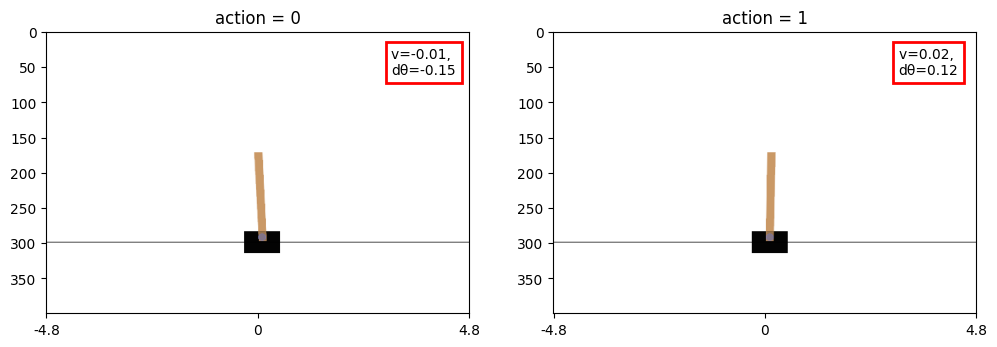

In [10]:
from policy_distillation.render import render_cartpole as render_fn

fig, ax = plt.subplots(1,2, figsize=(12,8))

for i, synth_state in enumerate(final_dataset):
    img = render_fn(synth_state, env_params)
    ax[i].imshow(img, label="hello")
    ax[i].set_title(f"action = {action_labels[i]}")
    
    x_dot = synth_state[1].item()
    theta_dot = synth_state[3].item()
    
    print(synth_state)
    
    ax[i].set_xticks([0, 600/2, 600], [-4.8, 0, 4.8])
    ax[i].text(490, 60, f"v={x_dot:.2f}, \ndθ={theta_dot:.2f}", bbox=dict(fill=False, edgecolor='red', linewidth=2))

## TODO:

1. Investigate nan / fitness computation for CartPole
    - Division by zero if episodes not done


## Generalization

### TODO:
- Turn this into function
- Do this for both tanh and relu activations
- Do this for multiple ES runs

In [11]:
width_list = [2,4,8,16,32,64,128,256,512,1024]
fit_list = {
            "relu" : [],
            "tanh" : []
           }
for width in width_list:
    new_config = config.copy()
    new_config["WIDTH"] = width
    new_config["UPDATE_EPOCHS"] = 10
    num_envs = 20
    
    fitness ={
            "relu" : -1,
            "tanh" : -1
           }
    
    for activation in ["relu", "tanh"]:
        new_config["ACTIVATION"] = activation

        final_dataset # Given
        action_labels # Given

        new_train_fn = make_train(new_config)

        def new_BC_train(rng_input, dataset):
            out = new_train_fn(dataset, action_labels, rng_input)
            return out  # ["metrics"]['returned_episode_returns'].mean()

        vmapped_BC_train = jax.jit(jax.vmap(new_BC_train, in_axes=(0, None)))

        rng, rng_new = jax.random.split(rng)
        rng_batch = jax.random.split(rng_new, num_envs)

        out_new = vmapped_BC_train(rng_batch, final_dataset)

        returns = out_new["metrics"]["returned_episode_returns"]  # dim=(popsize, rollout_news, num_steps, num_envs)
        dones = out_new["metrics"]["returned_episode"]  # same dim, True for last steps, False otherwise
        fitness[activation] = (returns * dones).sum(axis=(-1,-2)) / dones.sum(axis=(-1,-2))  # fitness, dim = (popsize)

        bc_loss = out_new['metrics']['bc_loss'][:,-1]

        fit_list[activation].append(fitness[activation])
    
    print(f"Width {width} : fitness (relu)={fitness['relu'].mean():.1f} +/- {fitness['relu'].std():.1f}, "
         + f"fitness (tanh)={fitness['tanh'].mean():.1f} +/- {fitness['tanh'].std():.1f}")
    

Width 2 : fitness (relu)=166.8 +/- 184.1, fitness (tanh)=284.6 +/- 176.4
Width 4 : fitness (relu)=283.4 +/- 139.7, fitness (tanh)=307.7 +/- 138.3
Width 8 : fitness (relu)=365.4 +/- 133.8, fitness (tanh)=413.9 +/- 100.6
Width 16 : fitness (relu)=465.0 +/- 84.1, fitness (tanh)=487.6 +/- 33.4
Width 32 : fitness (relu)=499.3 +/- 2.4, fitness (tanh)=498.4 +/- 5.3
Width 64 : fitness (relu)=495.8 +/- 13.1, fitness (tanh)=500.0 +/- 0.0
Width 128 : fitness (relu)=500.0 +/- 0.0, fitness (tanh)=500.0 +/- 0.0
Width 256 : fitness (relu)=500.0 +/- 0.0, fitness (tanh)=497.9 +/- 8.1
Width 512 : fitness (relu)=500.0 +/- 0.0, fitness (tanh)=486.7 +/- 58.1
Width 1024 : fitness (relu)=500.0 +/- 0.0, fitness (tanh)=500.0 +/- 0.0


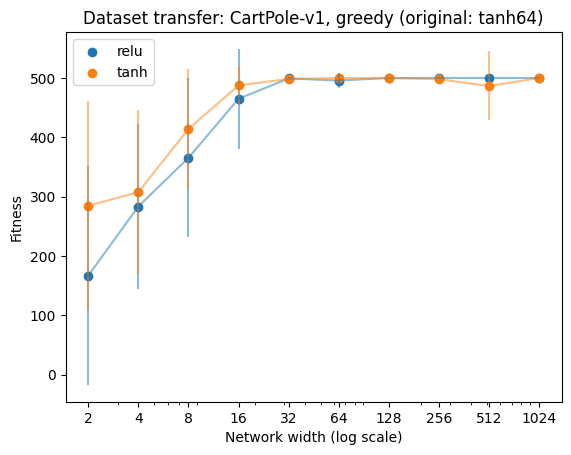

In [12]:
for activation, act_fit_list in fit_list.items():
    plt.scatter(width_list, [x.mean() for x in act_fit_list], label=activation)

    means = jnp.array([x.mean() for x in act_fit_list])
    stds = jnp.array([x.std() for x in act_fit_list])

    plt.errorbar(width_list, means, stds, alpha=0.5)
plt.ylabel("Fitness")
plt.xlabel("Network width (log scale)")
plt.xscale("log")
plt.xticks(width_list, width_list)

act = "greedy" if config["GREEDY_ACT"] else "softmax"
plt.title(f"Dataset transfer: {config['ENV_NAME']}, {act} (original: {config['ACTIVATION']}{config['WIDTH']})")
plt.legend()
plt.show()

## Trying a hand-made dataset

In [13]:

# fake_dataset = jnp.array(
# [[0.2, -0.1, -0.1, -0.4],
# [1.0, 0.3, 0.6, 0.25]]
# )

# fig, ax = plt.subplots(1,2, figsize=(12,8))

# for i, synth_state in enumerate(fake_dataset):
#     img = render_fn(synth_state, env_params)
#     ax[i].imshow(img, label="hello")
#     ax[i].set_title(f"action = {action_labels[i]}")
    
#     x_dot = synth_state[1].item()
#     theta_dot = synth_state[3].item()
    
#     print(synth_state)
    
#     ax[i].set_xticks([0, 600/2, 600], [-4.8, 0, 4.8])
#     ax[i].text(490, 60, f"v={x_dot:.2f}, \ndθ={theta_dot:.2f}", bbox=dict(fill=False, edgecolor='red', linewidth=2))

In [14]:
# width_list = [2,4,8,16,32,64,128,256,512,1024]
# fit_list = {
#             "relu" : [],
#             "tanh" : []
#            }
# for width in width_list:
#     new_config = config.copy()
#     new_config["WIDTH"] = width
#     new_config["UPDATE_EPOCHS"] = 10
#     num_envs = 20
    
#     fitness ={
#             "relu" : -1,
#             "tanh" : -1
#            }
    
#     for activation in ["relu", "tanh"]:
#         new_config["ACTIVATION"] = activation

#         new_train_fn = make_train(new_config)

#         def new_BC_train(rng_input, dataset):
#             out = new_train_fn(dataset, action_labels, rng_input)
#             return out  # ["metrics"]['returned_episode_returns'].mean()

#         vmapped_BC_train = jax.jit(jax.vmap(new_BC_train, in_axes=(0, None)))

#         rng, rng_new = jax.random.split(rng)
#         rng_batch = jax.random.split(rng_new, num_envs)

#         out_new = vmapped_BC_train(rng_batch, fake_dataset)

#         returns = out_new["metrics"]["returned_episode_returns"]  # dim=(popsize, rollout_news, num_steps, num_envs)
#         dones = out_new["metrics"]["returned_episode"]  # same dim, True for last steps, False otherwise
#         fitness[activation] = (returns * dones).sum(axis=(-1,-2)) / dones.sum(axis=(-1,-2))  # fitness, dim = (popsize)

#         bc_loss = out_new['metrics']['bc_loss'][:,-1]

#         fit_list[activation].append(fitness[activation])
    
#     print(f"Width {width} : fitness (relu)={fitness['relu'].mean():.1f} +/- {fitness['relu'].std():.1f}, "
#          + f"fitness (tanh)={fitness['tanh'].mean():.1f} +/- {fitness['tanh'].std():.1f}")
    

In [15]:
# for activation, act_fit_list in fit_list.items():
#     plt.scatter(width_list, [x.mean() for x in act_fit_list], label=activation)

#     means = jnp.array([x.mean() for x in act_fit_list])
#     stds = jnp.array([x.std() for x in act_fit_list])

#     plt.errorbar(width_list, means, stds, alpha=0.5)
# plt.ylabel("Fitness")
# plt.xlabel("Network width (log scale)")
# plt.xscale("log")
# plt.xticks(width_list, width_list)
# plt.title(f"Dataset transfer (original: {config['ACTIVATION']}{config['WIDTH']} )")
# plt.legend()
# plt.show()